In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


code from main.py

In [ ]:
!jar xvf /content/drive/MyDrive/cs425/hw5.zip

###Have not used this main.py script to run code, create my own script in the latter part of the pdf

In [ ]:
#Starter code prepared by Borna Ghotbi, Polina Zablotskaia, and Ariel Shann for Computer Vision
#based on a MATLAB code by James Hays and Sam Birch 

import numpy as np
from util import load, build_vocabulary, get_bags_of_sifts
from classifiers import nearest_neighbor_classify, svm_classify

#For this assignment, you will need to report performance for sift features on two different classifiers:
# 1) Bag of sift features and nearest neighbor classifier
# 2) Bag of sift features and linear SVM classifier

#For simplicity you can define a "num_train_per_cat" vairable, limiting the number of
#examples per category. num_train_per_cat = 100 for intance.

#Sample images from the training/testing dataset. 
#You can limit number of samples by using the n_sample parameter.

print('Getting paths and labels for all train and test data\n')
train_image_paths, train_labels = load("hw5/sift/train")
test_image_paths, test_labels = load("hw5/sift/test")
       

''' Step 1: Represent each image with the appropriate feature
 Each function to construct features should return an N x d matrix, where
 N is the number of paths passed to the function and d is the 
 dimensionality of each image representation. See the starter code for
 each function for more details. '''

        
print('Extracting SIFT features\n')
#TODO: You code build_vocabulary function in util.py
kmeans = build_vocabulary(train_image_paths, vocab_size=200)

#TODO: You code get_bags_of_sifts function in util.py 
train_image_feats = get_bags_of_sifts(train_image_paths, kmeans)
test_image_feats = get_bags_of_sifts(test_image_paths, kmeans)
        
#If you want to avoid recomputing the features while debugging the
#classifiers, you can either 'save' and 'load' the extracted features
#to/from a file.

''' Step 2: Classify each test image by training and using the appropriate classifier
 Each function to classify test features will return an N x l cell array,
 where N is the number of test cases and each entry is a string indicating
 the predicted one-hot vector for each test image. See the starter code for each function
 for more details. '''

print('Using nearest neighbor classifier to predict test set categories\n')
#TODO: YOU CODE nearest_neighbor_classify function from classifers.py
pred_labels_knn = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)
  

print('Using support vector machine to predict test set categories\n')
#TODO: YOU CODE svm_classify function from classifers.py
pred_labels_svm = svm_classify(train_image_feats, train_labels, test_image_feats)



print('---Evaluation---\n')
# Step 3: Build a confusion matrix and score the recognition system for 
#         each of the classifiers.
# TODO: In this step you will be doing evaluation. 
# 1) Calculate the total accuracy of your model by counting number
#   of true positives and true negatives over all. 
# 2) Build a Confusion matrix and visualize it. 
#   You will need to convert the one-hot format labels back
#   to their category name format.


# Interpreting your performance with 100 training examples per category:
#  accuracy  =   0 -> Your code is broken (probably not the classifier's
#                     fault! A classifier would have to be amazing to
#                     perform this badly).
#  accuracy ~= .10 -> Your performance is chance. Something is broken or
#                     you ran the starter code unchanged.
#  accuracy ~= .40 -> Rough performance with bag of SIFT and nearest
#                     neighbor classifier. 
#  accuracy ~= .50 -> You've gotten things roughly correct with bag of
#                     SIFT and a linear SVM classifier.
#  accuracy >= .60 -> You've added in spatial information somehow or you've
#                     added additional, complementary image features. This
#                     represents state of the art in Lazebnik et al 2006.
#  accuracy >= .85 -> You've done extremely well. This is the state of the
#                     art in the 2010 SUN database paper from fusing many 
#                     features. Don't trust this number unless you actually
#                     measure many random splits.
#  accuracy >= .90 -> You used modern deep features trained on much larger
#                     image databases.
#  accuracy >= .96 -> You can beat a human at this task. This isn't a
#                     realistic number. Some accuracy calculation is broken
#                     or your classifier is cheating and seeing the test
#                     labels.


util.py

In [3]:
import numpy as np
import os
import glob
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random

def build_vocabulary(image_paths, vocab_size):
    """ Sample SIFT descriptors, cluster them using k-means, and return the fitted k-means model.
    NOTE: We don't necessarily need to use the entire training dataset. You can use the function
    sample_images() to sample a subset of images, and pass them into this function.

    Parameters
    ----------
    image_paths: an (n_image, 1) array of image paths.
    vocab_size: the number of clusters desired.
    
    Returns
    -------
    kmeans: the fitted k-means clustering model.
    """
    n_image = len(image_paths)

    # Since want to sample tens of thousands of SIFT descriptors from different images, we
    # calculate the number of SIFT descriptors we need to sample from each image.
    n_each = int(np.ceil(10000 / n_image))

    # Initialize an array of features, which will store the sampled descriptors
    # keypoints = np.zeros((n_image * n_each, 2))
    descriptors = np.zeros((n_image * n_each, 128))

    for i, path in enumerate(image_paths):
        # Load features from each image
        features = np.loadtxt(path, delimiter=',',dtype=float)
        sift_keypoints = features[:, :2]
        sift_descriptors = features[:, 2:]

         # TODO: Randomly sample n_each descriptors from sift_descriptor and store them into descriptors
        des_size = features.shape[0]
        sample = random.sample(range(0, des_size), n_each)

        for j in range(n_each):
          descriptors[(i-1)*n_each + j]= sift_descriptors[sample[j]]


       

    # TODO: pefrom k-means clustering to cluster sampled sift descriptors into vocab_size regions.
    # You can use KMeans from sci-kit learn.
    # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    
    kmeans = KMeans(n_clusters=vocab_size, random_state=0).fit(descriptors)
    
    return kmeans
    
def get_bags_of_sifts(image_paths, kmeans):
    """ Represent each image as bags of SIFT features histogram.

    Parameters
    ----------
    image_paths: an (n_image, 1) array of image paths.
    kmeans: k-means clustering model with vocab_size centroids.

    Returns
    -------
    image_feats: an (n_image, vocab_size) matrix, where each row is a histogram.
    """
    n_image = len(image_paths)
    vocab_size = kmeans.cluster_centers_.shape[0]

    image_feats = np.zeros((n_image, vocab_size))

    for i, path in enumerate(image_paths):
        # Load features from each image
        features = np.loadtxt(path, delimiter=',',dtype=float)

        # TODO: Assign each feature to the closest cluster center
        # Again, each feature consists of the (x, y) location and the 128-dimensional sift descriptor
        # You can access the sift descriptors part by features[:, 2:]
        sift_descriptors = features[:, 2:]
        for j in range(features.shape[0]):
          # find the closest cluster center
          centre = kmeans.predict([sift_descriptors[j]])
          image_feats[i][centre[0]] += 1
      
      # TODO: Build a histogram normalized by the number of descriptors
        image_feats[i] = image_feats[i]/features.shape[0]

        

    return image_feats

# plot the average histogram for every category

def plotAvgHistogram(image_paths,image_labels, cates, image_feats,vocab_size,num_cate):
  n_image = len(image_paths)
  plot_feats = np.zeros((num_cate, vocab_size))
  num_pics = np.zeros((num_cate, 1))
  classes = ["" for x in range(num_cate)]

#simply sum histograms of each training image in each category
  for i, path in enumerate(image_paths):
    category = int(image_labels[i])
    
    plot_feats[category] += image_feats[i]
    num_pics[category] += 1
    classes[category] = cates[i]

#then average the histogram by the num of pictures in each category  
  for j in range(num_cate):
    hist = plot_feats[j]/num_pics[j]
    print(classes[j])
    a = np.arange(vocab_size)
    plt.hist(a,bins=vocab_size, weights=hist)
    
    plt.show()




def load(ds_path):
    """ Load from the training/testing dataset.

    Parameters
    ----------
    ds_path: path to the training/testing dataset.
             e.g., sift/train or sift/test 
    
    Returns
    -------
    image_paths: a (n_sample, 1) array that contains the paths to the descriptors. 
    labels: class labels corresponding to each image
    cates: class text labels corresponding to each image
    """
    # Grab a list of paths that matches the pathname
    files = glob.glob(os.path.join(ds_path, "*", "*.txt"))
    n_files = len(files)
    image_paths = np.asarray(files)
 
    # Get class labels (include text labels: cates)
    classes = glob.glob(os.path.join(ds_path, "*"))
    labels = np.zeros(n_files)
    cates = ["" for x in range(n_files)]

    for i, path in enumerate(image_paths):
        folder, fn = os.path.split(path)
        labels[i] = np.argwhere(np.core.defchararray.equal(classes, folder))[0,0]
        cates[i] = classes[int(labels[i])]

    # Randomize the order
    idx = np.random.choice(n_files, size=n_files, replace=False)
    image_paths = image_paths[idx]
    labels = labels[idx]
    cates = np.asarray(cates)
    cates = cates[idx]

    return image_paths, labels, cates


if __name__ == "__main__":
    paths, labels, cates = load("sift/train")
    #build_vocabulary(paths, 10)


hw5/sift/train/Bedroom


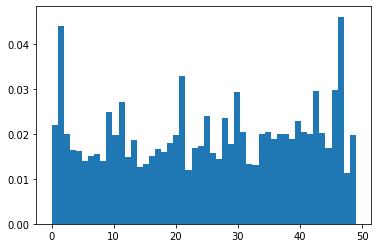

hw5/sift/train/Store


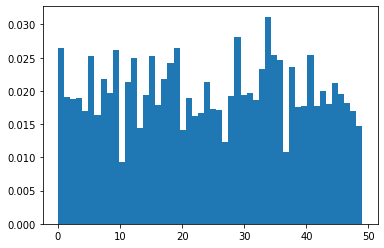

hw5/sift/train/Coast


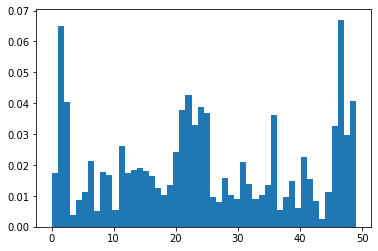

hw5/sift/train/LivingRoom


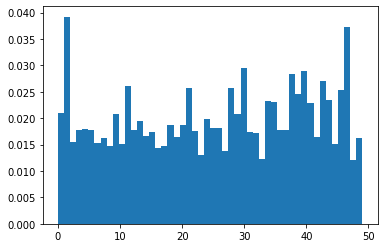

hw5/sift/train/TallBuilding


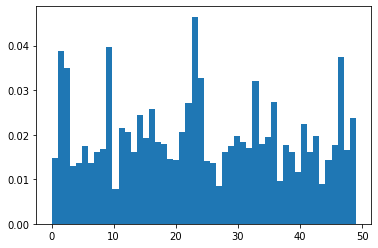

hw5/sift/train/InsideCity


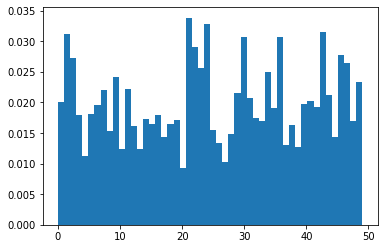

hw5/sift/train/Street


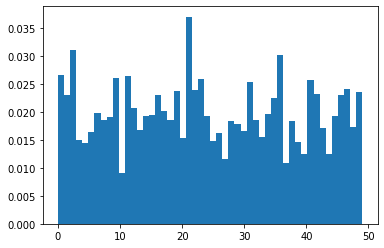

hw5/sift/train/Office


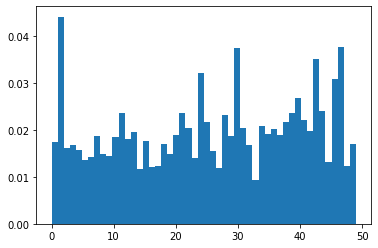

hw5/sift/train/OpenCountry


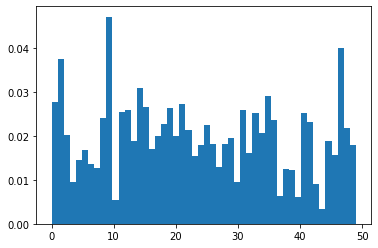

hw5/sift/train/Mountain


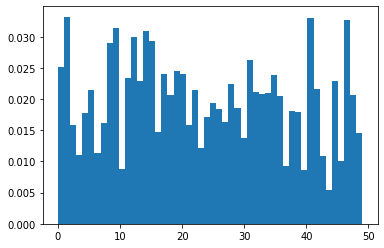

hw5/sift/train/Industrial


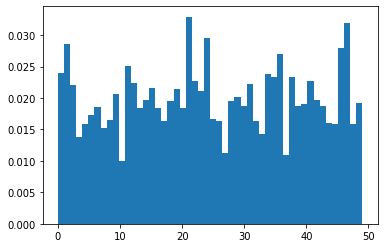

hw5/sift/train/Forest


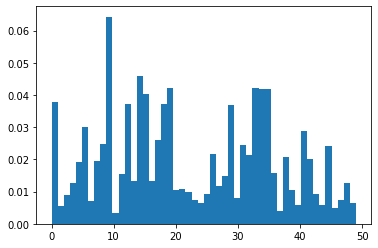

hw5/sift/train/Highway


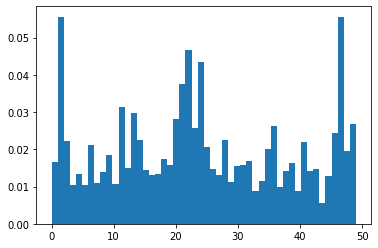

hw5/sift/train/Suburb


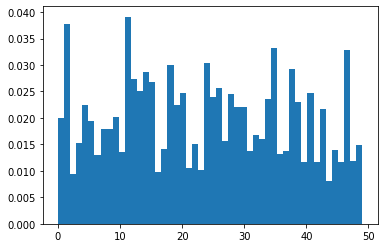

hw5/sift/train/Kitchen


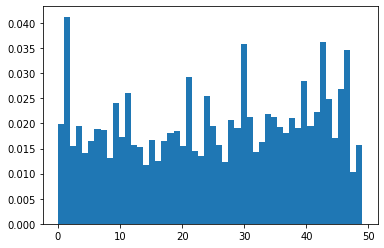

In [ ]:
train_image_paths, train_labels, train_cates = load("hw5/sift/train")
#test_image_paths, test_labels = load("hw5/sift/test")

#TODO: You code build_vocabulary function in util.py
kmeans = build_vocabulary(train_image_paths, vocab_size=50)

#TODO: You code get_bags_of_sifts function in util.py 
train_image_feats = get_bags_of_sifts(train_image_paths, kmeans)
#test_image_feats = get_bags_of_sifts(test_image_paths, kmeans)

plotAvgHistogram(train_image_paths,train_labels,train_cates,train_image_feats,50,15)
#*******Append the entire output at the end of the pdf********


##### Distinguish between categories
Most of the histograms have totally different shape, they have peaks at different bins (cluster centre) and different numbers of peaks. However, I feel that it would be difficult to distinguish between category: Kitchen and Office. For this group, both histograms share the similar trait: At the very first bin, they have a peak, then at the central two bins, they have 2-3 peaks, at the very last 3 bins, they have 2-3 peaks.  

classifier.py

In [45]:
 #Starter code prepared by Borna Ghotbi for computer vision
 #based on MATLAB code by James Hay
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt  
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn import svm
'''This function will predict the category for every test image by finding
the training image with most similar features. Instead of 1 nearest
neighbor, you can vote based on k nearest neighbors which will increase
performance (although you need to pick a reasonable value for k). '''

def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats,k):


    '''
    Parameters
        ----------
        train_image_feats:  is an N x d matrix, where d is the dimensionality of the feature representation.
        train_labels: is an N x l cell array, where each entry is a string 
        			  indicating the ground truth one-hot vector for each training image.
    	test_image_feats: is an M x d matrix, where d is the dimensionality of the
    					  feature representation. You can assume M = N unless you've modified the starter code.
          k: k nearest neighbor
        
    Returns
        -------
    	classifier: a classifier which get from training on the train image sets

    Usefull funtion:
    	
    	# You can use knn from sci-kit learn.
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    '''

    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_image_feats, train_labels)
    #predicted_labels = neigh.predict(test_image_feats)
    classifier = neigh

    return classifier

#print the text labels (follow the order of test_labels)
def transferLabelToString(test_labels,test_cates):
    classes = ["" for x in range(15)]


    for i in range(len(test_labels)):
        category = int(test_labels[i])
        classes[category] = test_cates[i]

    return classes



'''This function will train a linear SVM for every category (i.e. one vs all)
and then use the learned linear classifiers to predict the category of
very test image. Every test feature will be evaluated with all 15 SVMs
and the most confident SVM will "win". Confidence, or distance from the
margin, is W*X + B where '*' is the inner product or dot product and W and
B are the learned hyperplane parameters. '''

def svm_classify(train_image_feats, train_labels, test_image_feats, c):

    '''
    Parameters
        ----------
        train_image_feats:  is an N x d matrix, where d is the dimensionality of the feature representation.
        train_labels: is an N x l cell array, where each entry is a string 
        			  indicating the ground truth one-hot vector for each training image.
    	test_image_feats: is an M x d matrix, where d is the dimensionality of the
    					  feature representation. You can assume M = N unless you've modified the starter code.
              C: hyperparameter for regularity
        
    Returns
        -------
    classifier: a svm classifier which get from training on the train image sets

    Usefull funtion:
    	
    	# You can use svm from sci-kit learn.
        # Reference: https://scikit-learn.org/stable/modules/svm.html

    '''
    lin_clf = svm.LinearSVC(C=c)
    lin_clf.fit(train_image_feats, train_labels)
    #predicted_labels = lin_clf.predict(test_image_feats)
    classifier = lin_clf
    return classifier



In [25]:
train_image_paths, train_labels, train_cates = load("hw5/sift/train")
test_image_paths, test_labels, test_cates = load("hw5/sift/test")

#TODO: You code build_vocabulary function in util.py
kmeans = build_vocabulary(train_image_paths, vocab_size=50)

#TODO: You code get_bags_of_sifts function in util.py 
train_image_feats = get_bags_of_sifts(train_image_paths, kmeans)
np.save('train_image_feats', train_image_feats)
test_image_feats = get_bags_of_sifts(test_image_paths, kmeans)
np.save('test_image_feats', test_image_feats)


In [15]:
#Total number of test images, used for accuracy calculation
print(len(test_image_paths))

450


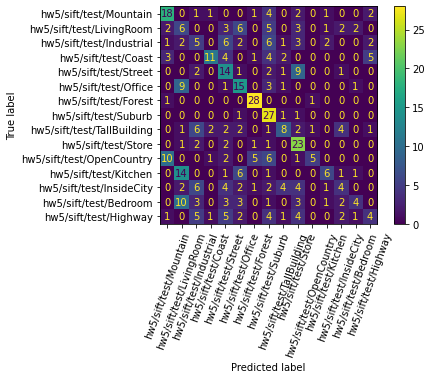

In [20]:
train_image_feats = np.load('train_image_feats.npy')
test_image_feats = np.load('test_image_feats.npy')

print('Using nearest neighbor classifier to predict test set categories\n')
#TODO: YOU CODE nearest_neighbor_classify function from classifers.py
# Get the knn classifier
pred_labels_knn = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats,10)
#Get the display labels
classes = transferLabelToString(test_labels, test_cates)
plot_confusion_matrix(pred_labels_knn, test_image_feats, test_labels, display_labels=classes,xticks_rotation=70) 

#Accuracy = number of true positive（# on the diagonal） / # number of labels
#k=1 accuracy = 34%
#k=3 accuracy =35.1%
#k=10 accuracy = 39.5% = 178/450
#k=20 accuracy = 39.1%
#k=30 accuracy = 37.1%
'''
Under the condition: vocab_size=50, According to the expriments, pick the best k =10
and the confusion matrix is following, the accuracy is equal to 39.5%
We can vote based on k nearest neighbors which will increase
performance of classifier as k increase to 10. While k is over 10, 
the accuracy start to drop down, this is probably because: 
the number of options increase will disturb the judgement of the predictions, 
reduce the accuracy (many neighbors may gain the same votes).
Although more options(k increase) of the nearest neighbors may provide more information to our model,
we need to make the trade off to control the k in a reasonable range (around 10 in this case).

'''

Using support vector machine to predict test set categories



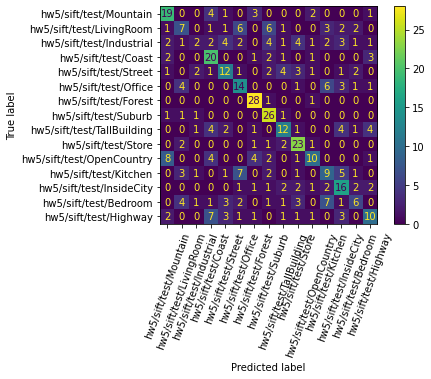

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print('Using support vector machine to predict test set categories\n')
#TODO: YOU CODE svm_classify function from classifers.py
#Get the svm classifier
train_image_feats = np.load('train_image_feats.npy')
test_image_feats = np.load('test_image_feats.npy')
pred_labels_svm = svm_classify(train_image_feats, train_labels, test_image_feats,10)
#get the display labels
classes = transferLabelToString(test_labels, test_cates)
plot_confusion_matrix(pred_labels_svm, test_image_feats, test_labels, display_labels=classes,xticks_rotation=70) 

#Accuracy = number of true positive（# on the diagonal） / # number of labels
#C=20, accuracy =46.2%
#C=10, accuracy =47.5% =214/450
#C=5,  accuracy =47.3%
#C=2, accuracy =44.8%
#C=1, accuracy = 43.3%
#C=0.9, accuracy =44.2%
#C=0.8, accuracy = 43.7%
#C=0.5, accuracy = 40.6%

'''
Under the condition: vocab_size=50, According to the expriments, pick the best C = 10
and the confusion matrix is following. The accuracy is equal to 47.5%. The default value is c=1, 
it gives accuracy: 43.3%. When decrese the C from the default value, the accuracy will first increase
and achive a small peak (not max) around c=0.9, and then sharply decrease as the c decrease. 
I think it probably because: we have some amounts of noisy observations, decreasing C corresponds to
more regularization. But too small value of C can also limit the accuracy.
LinearSVC  will less sensitive to C when it becomes large, and prediction results will improving as
the C increase, but it will stop improving after a certain threshold (in this case it should be some value
larger than 20). 

'''



